In [1]:
import os
import time
import math
import random
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path
from tabulate import tabulate
from shutil import copy, copytree
from typing import Optional, Dict

import tensorflow as tf
from keras import layers
import keras.backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing import image
from keras.applications import DenseNet121
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

2024-07-10 02:45:40.722223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 02:45:40.722334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 02:45:40.844399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Download Data

In [2]:
data_path = Path(r"/kaggle/input/caltech-101-5-folds")

### Import folds using number of fold

In [3]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical

def load_fold(base_path, fold_num, subset, target_size=(224, 224)):
    fold_dir = os.path.join(base_path, f"fold_{fold_num}", subset)
    X = []
    y = []

    for class_dir in os.listdir(fold_dir):
        
        class_path = os.path.join(fold_dir, class_dir)
        label = int(class_dir.split('_')[-1])

        # Loop through each image in the class directory
        for img_name in os.listdir(class_path):
            
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype='float32') / 255.0  # Normalize images
    y = to_categorical(np.array(y), num_classes=len(os.listdir(fold_dir)))
    
    return X, y

fold_num = 5
X_train, y_train = load_fold(data_path, fold_num, "train")
X_test, y_test = load_fold(data_path, fold_num, "test")

In [4]:
len(X_train), len(y_train), len(X_test), len(y_test)

(7316, 7316, 1828, 1828)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, val_index in split.split(X_train, y_train.argmax(axis=1)):
    X_train_new, X_val = X_train[train_index], X_train[val_index]
    y_train_new, y_val = y_train[train_index], y_train[val_index]


In [6]:
X_train = X_train_new
y_train = y_train_new

print(f"Training data: {X_train.shape[0]}")
print(f"Validation data: {X_val.shape[0]}")
print(f"Test data: {X_test.shape[0]}")


Training data: 5852
Validation data: 1464
Test data: 1828


In [7]:
import numpy as np

# Assuming y_train_new, y_val, y_test are your one-hot encoded label arrays
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Get unique classes across all datasets
unique_classes = np.unique(np.concatenate([y_train_classes, y_val_classes, y_test_classes]))

# Print counts for each class
for cls in unique_classes:
    train_count = np.sum(y_train_classes == cls)
    val_count = np.sum(y_val_classes == cls)
    test_count = np.sum(y_test_classes == cls)
    print(f"Class {cls}: Train: {train_count}, Validation: {val_count}, Test: {test_count}")


Class 0: Train: 299, Validation: 75, Test: 93
Class 1: Train: 278, Validation: 70, Test: 87
Class 2: Train: 278, Validation: 70, Test: 87
Class 3: Train: 128, Validation: 32, Test: 40
Class 4: Train: 511, Validation: 128, Test: 159
Class 5: Train: 35, Validation: 9, Test: 11
Class 6: Train: 512, Validation: 128, Test: 160
Class 7: Train: 27, Validation: 7, Test: 8
Class 8: Train: 26, Validation: 7, Test: 9
Class 9: Train: 30, Validation: 7, Test: 10
Class 10: Train: 35, Validation: 9, Test: 10
Class 11: Train: 30, Validation: 7, Test: 9
Class 12: Train: 21, Validation: 5, Test: 7
Class 13: Train: 81, Validation: 21, Test: 26
Class 14: Train: 62, Validation: 16, Test: 20
Class 15: Train: 28, Validation: 7, Test: 8
Class 16: Train: 54, Validation: 14, Test: 17
Class 17: Train: 58, Validation: 14, Test: 19
Class 18: Train: 32, Validation: 8, Test: 10
Class 19: Train: 28, Validation: 7, Test: 8
Class 20: Train: 79, Validation: 20, Test: 24
Class 21: Train: 30, Validation: 7, Test: 10
Class

In [8]:
import tensorflow.keras.backend as K

def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """Calculates the F1 score."""
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """Calculates the specificity."""
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """Calculates the sensitivity."""
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        This approach allows for a nuanced assessment of the model's ability to distinguish
        between different classes, making it particularly valuable in scenarios where classes
        may have varying levels of significance.

        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """Calculates the number of true positives."""
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """Calculates the number of false positives."""
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """Calculates the number of false negatives."""
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """Calculates the number of true negatives."""
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """Calculates the components of the confusion matrix."""
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )


# precision_metric, recall_metric, f1_score_metric, specificity_metric, sensitivity_metric, mcc_metric, auc_metric = custom_metrics

In [9]:
class MaxMinPooling2D(layers.Layer):
    """
    Custom layer that performs max-min pooling on a 2D input tensor.
    """

    def __init__(self, pool_size=(2, 2), strides=2, padding="SAME", **kwargs):
        """
        Initialize the MaxMinPooling2D layer.

        Args:
            pool_size (tuple): Size of the pooling window (default: (2, 2)).
            strides (int): Stride size for the pooling window (default: 2).
            padding (str): Padding mode for the input tensor (default: "SAME").
            **kwargs: Additional keyword arguments passed to the base class constructor.
        """
        super(MaxMinPooling2D, self).__init__(**kwargs)

        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def get_config(self):
        """
        Get the configuration of the MaxMinPooling2D layer.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding
        })
        return config

    def call(self, inputs, **kwargs):
        """
        Perform the computation for the MaxMinPooling2D layer.

        Args:
            inputs (tf.Tensor): Input tensor.
            **kwargs: Additional keyword arguments.

        Returns:
            tf.Tensor: Output tensor.
        """
        # Extract patches from the input tensor
        patch = tf.image.extract_patches(inputs,
                                         sizes=[1, self.pool_size[0], self.pool_size[1], 1],
                                         strides=[1, self.strides, self.strides, 1],
                                         rates=[1, 1, 1, 1],
                                         padding=self.padding)

        # Reshape the patches to group pixels within each patch together
        patch = tf.reshape(patch, (tf.shape(patch)[0], tf.shape(patch)[1], tf.shape(patch)[2],
                                   self.pool_size[0] * self.pool_size[1], tf.shape(inputs)[-1]))

        # Compute element-wise difference between max and min values within each patch
        output = tf.math.reduce_max(patch, axis=3) - tf.math.reduce_min(patch, axis=3)

        # Cast the output tensor to float32 if needed
        if output.dtype != tf.float32:
            output = tf.cast(output, tf.float32)

        return output

In [10]:
model = DenseNet121(weights='imagenet')
model.trainable = True
model.summary()

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
layer_name_1 = 'conv5_block14_concat'

selected_layer_1_output = model.get_layer(layer_name_1).output

x = MaxPooling2D(pool_size=(5, 5))(selected_layer_1_output)
x = MaxMinPooling2D(pool_size=(5, 5), name="maxmin_pooling")(selected_layer_1_output)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)

layer_name_2 = 'avg_pool'

selected_layer_2_output = model.get_layer(layer_name_2).output

concatenated_output = tf.keras.layers.concatenate([selected_layer_2_output, x], axis=-1)

dense_output = tf.keras.layers.Dense(102, activation='softmax')(concatenated_output)

new_model = tf.keras.Model(inputs=model.input, outputs=dense_output)

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,309,974 (27.89 MB)

 Trainable params: 7,226,326 (27.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

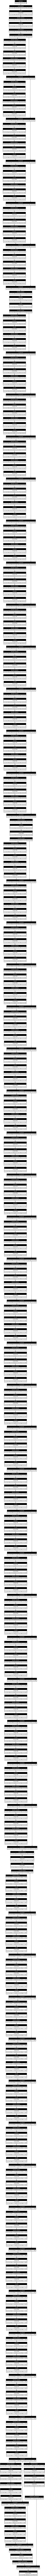

In [12]:
plot_model(new_model, to_file='modified_model.png', show_shapes=True, show_layer_activations=True)

In [13]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

time_callback = TimeCallback()

In [14]:
learningRate = 1e-4
decayRate = 0.97

def lr_schedule(epoch):
    if epoch < 2:
        return learningRate
    else:
        return learningRate * decayRate ** epoch

learning_callback = LearningRateScheduler(lr_schedule)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
custom_metrics = list(create_metrics())
custom_metrics.append("accuracy")

In [17]:
new_model.compile(
    optimizer=Adam(learning_rate=learningRate),
    loss='categorical_crossentropy',
    metrics=custom_metrics
#     metrics=['accuracy', create_metrics()]
)

history = new_model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=50,
    callbacks=[time_callback, learning_callback, early_stopping]
)

Epoch 1/50


I0000 00:00:1720579785.177816      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 346s 969ms/step - accuracy: 0.4431 - auc: 0.8548 - f1_score: 0.3954 - loss: 2.7501 - mcc: 0.4526 - precision: 0.9280 - recall: 0.2790 - sensitivity: 0.2790 - specificity: 0.9999 - val_accuracy: 0.8798 - val_auc: 0.9967 - val_f1_score: 0.8180 - val_loss: 0.6767 - val_mcc: 0.8288 - val_precision: 0.9819 - val_recall: 0.7036 - val_sensitivity: 0.7031 - val_specificity: 0.9999 - learning_rate: 1.0000e-04
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9554 - auc: 0.9994 - f1_score: 0.9157 - loss: 0.3471 - mcc: 0.9184 - precision: 0.9920 - recall: 0.8529 - sensitivity: 0.8529 - specificity: 0.9999 - val_accuracy: 0.9365 - val_auc: 0.9976 - val_f1_score: 0.9214 - val_loss: 0.3228 - val_mcc: 0.9226 - val_precision: 0.9764 - val_recall: 0.8750 - val_sensitivity: 0.8745 - val_specificity: 0.9998 - learning_rate: 1.0000e-04
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9918 - auc: 1.0000 - f1_score: 0.9890 - loss: 0.0917 - 

In [18]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 15 minutes, 44 seconds, 482 milliseconds
Average time per epoch: 58 seconds, 885 milliseconds


In [19]:
_ = new_model.evaluate(X_test,y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 293ms/step - accuracy: 0.9489 - auc: 0.9940 - f1_score: 0.9502 - loss: 0.1971 - mcc: 0.9499 - precision: 0.9651 - recall: 0.9370 - sensitivity: 0.9369 - specificity: 0.9997


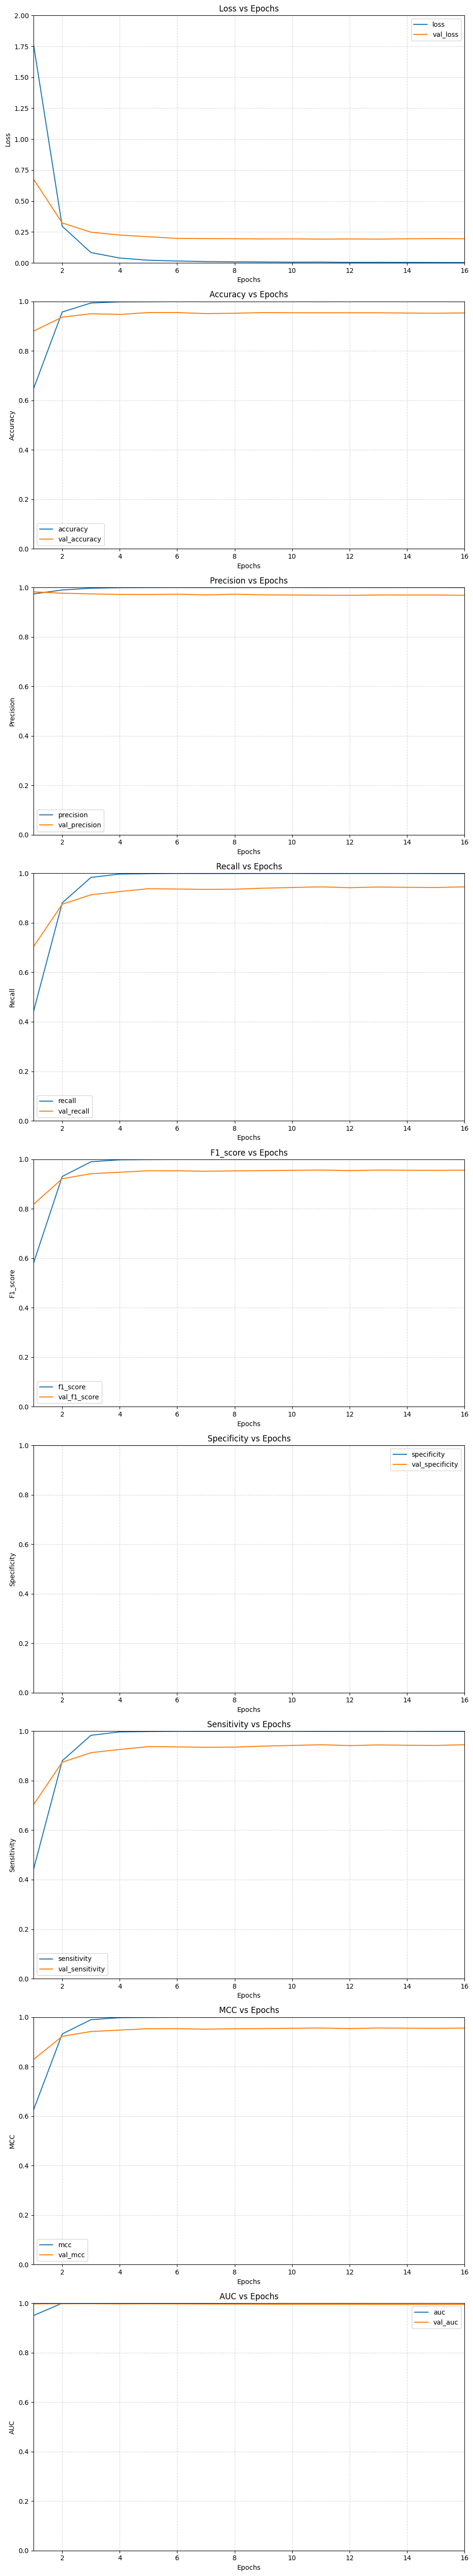

In [20]:
def plot_metrics(history, metric_name_list, figure_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        history: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        figure_size: a tuple specifying the size of the figure (width, height)

    Returns:
        None
    """
    # Check if history is a valid Keras History object
    if not isinstance(history, type(tf.keras.callbacks.History())):
        raise ValueError("Invalid Keras History object provided.")

    num_metrics = len(metric_name_list)

    # Create subplots
    figure, axes = plt.subplots(num_metrics, figsize=(figure_size[0], figure_size[1] * num_metrics))

    # Define x-axis range
    rng = range(1, len(history.history[metric_name_list[0]]) + 1)

    for ax, metric_name in zip(axes, metric_name_list):
        # Check if the metric exists in the history
        if metric_name not in history.history:
            raise ValueError(f"Metric '{metric_name}' not found in the training history.")

        metric = history.history[metric_name]
        v_metric = history.history.get(f"val_{metric_name}", None)

        # Plot training metric
        ax.plot(rng, metric, label=metric_name)

        # Plot validation metric if available
        if v_metric is not None:
            ax.plot(rng, v_metric, label=f"val_{metric_name}")

        ax.legend()
        ax.set_xlabel("Epochs")

        # Set y-axis label and title
        ylabel = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} vs Epochs")

        # Set y-axis limits
        max_loss = max(max(metric), max(v_metric)) if v_metric is not None else max(metric)
        min_loss = min(min(metric), min(v_metric)) if v_metric is not None else min(metric)
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()
    plt.show()

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [21]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming model is your trained model
# Predict probabilities for each class
y_pred_prob = new_model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test from one-hot encoded to categorical labels if needed
y_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the report
print(report)


58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        93
           1       0.99      1.00      0.99        87
           2       1.00      0.99      0.99        87
           3       1.00      1.00      1.00        40
           4       0.99      1.00      1.00       159
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       160
           7       0.86      0.75      0.80         8
           8       0.80      0.89      0.84         9
           9       1.00      1.00      1.00        10
          10       0.80      0.80      0.80        10
          11       1.00      0.67      0.80         9
          12       0.83      0.71      0.77         7
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00        20
          15       1.00      0.88      0.93         8
          16       1.00      0.94      